In [0]:
# Install Keras with pip
!pip install -q keras

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import json
import os
import pandas as pd
import re
import numpy as np
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.tokenize import word_tokenize
#import emoji

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#install wordcloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

#Train test split
from sklearn.model_selection import train_test_split

#Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#Models
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix,f1_score

#Impute
from sklearn.preprocessing import Imputer
#from missingpy import KNNImputer
from sklearn.impute import SimpleImputer

#datetime
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from xgboost.sklearn import XGBClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

In [7]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/sentimental_Analysis/Amazon_Unlocked_Mobile_cleaned.csv')
df.head()

,Unnamed: 0,clean_review,new_rating
0,0,i feel so lucky to have found this used phone ...,1
1,1,nice phone nice up grade from my pantach revue...,1
2,2,very pleased,1
3,3,it work good but it go slow sometimes but it a...,1
4,4,great phone to replace my lost phone the only ...,1


In [8]:
df.dtypes

Unnamed: 0       int64
clean_review    object
new_rating       int64
dtype: object

In [0]:
df=df.dropna()

In [10]:
df.shape

(234196, 3)

#Visualize the words

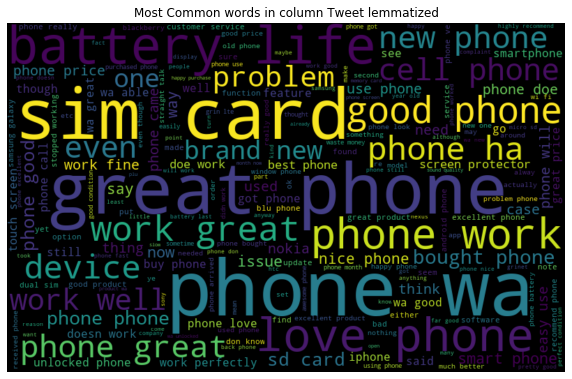

In [11]:
all_words= ' '.join([text for text in df['clean_review']])

wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet lemmatized")
plt.show()

#Visualize Negative review words

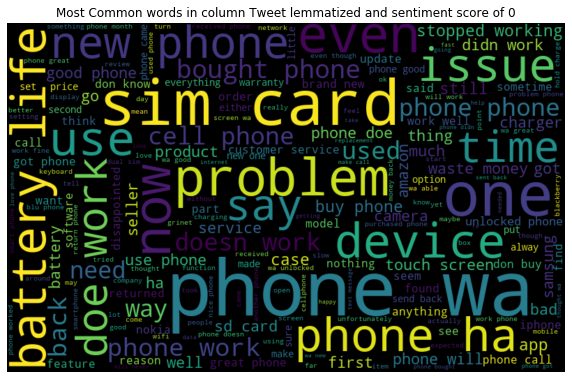

In [12]:
# Below word cloud will say us which word is more important for predicting sentiment score of 0

sentiment_score_0 = ' '.join([text for text in df['clean_review'][df['new_rating'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentiment_score_0)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet lemmatized and sentiment score of 0")
plt.show()

#Visualize postive review words


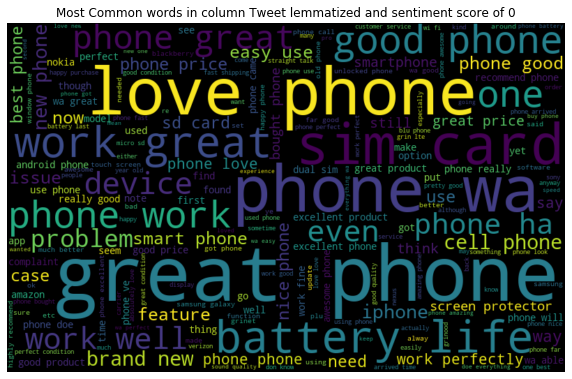

In [13]:
# Below word cloud will say us which word is more important for predicting sentiment score of 0

sentiment_score_0 = ' '.join([text for text in df['clean_review'][df['new_rating'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentiment_score_0)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet lemmatized and sentiment score of 0")
plt.show()

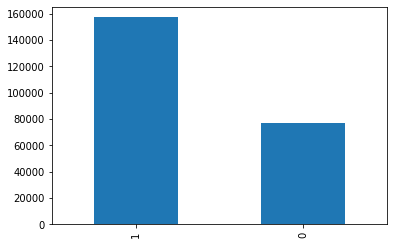

In [14]:
df['new_rating'].value_counts().plot(kind = "bar")

In [15]:
print(df['clean_review'].shape)
print(df['new_rating'].shape)

(234196,)
(234196,)


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU, LSTM, SpatialDropout1D,Bidirectional
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


#fit_on_texts
 Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).
#texts_to_sequences:
 Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [0]:
max_features=2000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(df['clean_review'])

In [0]:
x=tokenizer.texts_to_sequences(df['clean_review'])
x=pad_sequences(x)

In [19]:
print(x.shape)

(234196, 4501)


In [0]:
y=pd.get_dummies(df['new_rating']).values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

If random_state is an integer, then it is used to seed a new RandomState object.

This is to check and validate the data when running the code multiple times. Setting random_state a fixed value will guarantee that same sequence of random numbers are generated each time you run the code

In [21]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(163937, 4501) (163937, 2)
(70259, 4501) (70259, 2)


In [0]:
embed_dim=128

In [23]:
model=Sequential()
model.add(Embedding(max_features,embed_dim,input_length=x.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(96,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4501, 128)         256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 4501, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                86400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 194       
Total params: 342,594
Trainable params: 342,594
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
batch_size=32
#lstm1_model=model.fit(x_train,y_train,epochs=2#,batch_size=batch_size,validation_data=(x_test,y_test),verbose=1)

# using GRU Model

In [25]:
model_gru=Sequential()
model_gru.add(Embedding(max_features,embed_dim,input_length=x.shape[1],mask_zero=True))
model_gru.add(GRU(64,dropout=0.4,return_sequences=True))
model_gru.add(GRU(32,dropout=0.4,return_sequences=False))
model_gru.add(Dense(2,activation='softmax'))
model_gru.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model_gru.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4501, 128)         256000    
_________________________________________________________________
gru_1 (GRU)                  (None, 4501, 64)          37056     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 302,434
Trainable params: 302,434
Non-trainable params: 0
_________________________________________________________________


In [0]:
#gru_model=model_gru.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=2,verbose=1)

#Bidirectional GRU

In [27]:
model_bgru=Sequential()
model_bgru.add(Embedding(max_features,embed_dim,input_length=x.shape[1]))
model_bgru.add(Bidirectional(GRU(128,dropout=0.4,return_sequences=True)))
model_bgru.add(Bidirectional(GRU(64,dropout=0.4,return_sequences=False)))
model_bgru.add(Dense(2,activation='softmax'))
model_bgru.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model_bgru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4501, 128)         256000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4501, 256)         197376    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               123264    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 576,898
Trainable params: 576,898
Non-trainable params: 0
_________________________________________________________________


In [0]:
#model_bgru_fit=model_bgru.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,verbose=1,epochs=2)

#CNN 

In [29]:
model_cnn=Sequential()
model_cnn.add(Embedding(max_features,embed_dim,input_length=x.shape[1]))
model_cnn.add(Dropout(0.2))
model_cnn.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(2,activation='softmax'))
model_cnn.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 4501, 128)         256000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4501, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4501, 64)          24640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [0]:
early_stop=EarlyStopping(monitor="val_loss",mode='min',patience=3)

In [31]:
cnn_model=model_cnn.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=32,verbose=1,callbacks=[early_stop])




Train on 163937 samples, validate on 70259 samples
Epoch 1/10





163937/163937 [==============================] - 137s 836us/step - loss: 0.3191 - acc: 0.8614 - val_loss: 0.2368 - val_acc: 0.9090
Epoch 2/10
163937/163937 [==============================] - 121s 735us/step - loss: 0.2240 - acc: 0.9136 - val_loss: 0.2147 - val_acc: 0.9183
Epoch 3/10
163937/163937 [==============================] - 120s 734us/step - loss: 0.1988 - acc: 0.9253 - val_loss: 0.2008 - val_acc: 0.9255
Epoch 4/10
163937/163937 [==============================] - 120s 734us/step - loss: 0.1804 - acc: 0.9345 - val_loss: 0.1919 - val_acc: 0.9303
Epoch 5/10
163937/163937 [==============================] - 120s 734us/step - loss: 0.1645 - acc: 0.9420 - val_loss: 0.1857 - val_acc: 0.9331
Epoch 6/10
163937/163937 [==============================] - 121s 736us/step - loss: 0.1510 - acc: 0.9477 - val_loss: 0.1807 - val_acc: 0.9356
Epoch 7/10
163937/163937 [==============================] - 120s 733us/step - loss: 0.138

#Save the model

In [0]:
model_cnn.save('/content/drive/My Drive/Colab Notebooks/NLP/sentimental_Analysis/CNN_model_latest.h5')

#Load the model

In [0]:
model=load_model('/content/drive/My Drive/Colab Notebooks/NLP/sentimental_Analysis/CNN_model_latest.h5')

#Summarize the loaded model to verify

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 4501, 128)         256000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4501, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4501, 64)          24640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [0]:
# evaluate the model
#score = model.evaluate(X, Y, verbose=0)

#CNN with LSTM

In [44]:
model_cnn_lstm=Sequential()
model_cnn_lstm.add(Embedding(embed_dim,max_features,input_length=x.shape[1]))
model_cnn_lstm.add(Conv1D(64,kernel_size=3,padding='same',strides=1))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Dropout(0.25))
model_cnn_lstm.add(LSTM(128,return_sequences=True))
model_cnn_lstm.add(Dropout(0.3))
model_cnn_lstm.add(Flatten())
model_cnn_lstm.add(Dense(128,activation='relu'))
model_cnn_lstm.add(Dropout(0.3))
model_cnn_lstm.add(Dense(2,activation='softmax'))
model_cnn_lstm.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model_cnn_lstm.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 4501, 2000)        256000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 4501, 64)          384064    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2250, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2250, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2250, 128)         98816     
_________________________________________________________________
dropout_12 (Dropout)         (None, 2250, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 288000)          

In [0]:
history=model_cnn_lstm.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=2,batch_size=32,verbose=1,callbacks=[early_stop])

Train on 163937 samples, validate on 70259 samples
Epoch 1/2
  3808/163937 [..............................] - ETA: 6:41:08 - loss: 0.6443 - acc: 0.6670